<a href="https://colab.research.google.com/github/smsubham/Image-Caption-generator/blob/main/SCICAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Caption Generator
Image caption generator is a model which generates caption based on the features present in the input image.

## Introduction
The basic working of the project is that the features are extracted from the images using pre-trained VGG16 model and then fed to the LSTM model along with the captions to train. The trained model is then capable of generating captions for any images that are fed to it.

## Dependencies
* Keras
* Tensorflow GPU
* Pre-trained VGG-16 weights
* NLTK
* Matplotlib

## Steps to follow:

### Importing the required libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
from tensorflow.compat.v1.keras.backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
keras version 2.7.0
tensorflow version 2.7.0


In [ ]:
#pip install -U protobuf==3.8.0

## Configuring the GPU memory to be used for training purposes

In [ ]:
config = tf.compat.v1.ConfigProto
#config.gpu_options.per_process_gpu_memory_fraction = 0.95 #Using 95% of the available memory of the GPU
#config.gpu_options.visible_device_list = "0"
#set_session(tf.compat.v1.Session(config=config))

def set_seed(sd=144):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

In [ ]:
#we need to set file path and if download of files needed depending on if it runs on colab or local system.
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

## Importing the image dataset and its respective captions

In [ ]:
if IN_COLAB:
  !wget https://www.dropbox.com/s/t1sjqesl0pynaxo/scicap_data.zip?dl=0

--2021-12-27 21:57:13--  https://www.dropbox.com/s/t1sjqesl0pynaxo/scicap_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/t1sjqesl0pynaxo/scicap_data.zip [following]
--2021-12-27 21:57:13--  https://www.dropbox.com/s/raw/t1sjqesl0pynaxo/scicap_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9b60267f73995343a94323732b.dl.dropboxusercontent.com/cd/0/inline/BcoNyB9IYRpkFIymQ_IGE7UVdb-iiyOu6xZhEJ_Usmi9fW10VwTcYguLyKu83eQdETxAGvkP2QzaSVlk3yha60DwIVJk-jglOTxrcAheUab_O2ZNACTS0ebJJVhqUVlHeYqHzZvwy_w6IozCgsm-mepE/file# [following]
--2021-12-27 21:57:14--  https://uc9b60267f73995343a94323732b.dl.dropboxusercontent.com/cd/0/inline/BcoNyB9IYRpkFIymQ_IGE7UVdb-iiyOu6xZhEJ_Usmi9fW10VwTcYguLyKu83eQdETxAGvkP2Q

In [ ]:
if IN_COLAB:
  !unzip scicap_data.zip?dl=0

Streaming output truncated to the last 5000 lines.
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/1805.08531v4-Figure9-1.png  
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/1911.06317v4-Figure15-1.png  
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/2009.12919v2-Figure3-1.png  
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/1307.2783v4-Figure7-1.png  
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/2005.13144v1-Figure4-1.png  
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/1811.06144v1-Figure4-1.png  
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/1410.1966v1-Figure8-1.png  
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/1807.06752v1-Figure11-1.png  
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/1105.0819v3-Figure7-1.png  
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/2010.04391v1-Figure8-1.png  
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/2008.06368v1-Figure9-1.png  
  inflating: scicap_data/SciCap-Yes-Subfig-Img/test/2006.06

In [ ]:
os.listdir()

['.config', 'scicap_data', 'scicap_data.zip?dl=0', 'sample_data']

In [ ]:
fileNamePath = r"scicap_data/List-of-Files-for-Each-Experiments/First-Sentence/No-Subfig/train/file_idx.json"

if IN_COLAB:
  fileNamePath = r"/content/" + fileNamePath

firstSentenceTrainJSON = pd.read_json(fileNamePath)
firstSentenceTrainJSON = firstSentenceTrainJSON.rename({0: 'filename'}, axis=1)

print(firstSentenceTrainJSON.to_string()) 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
firstSentenceTrainJSON[:10]

,filename
0,1001.0025v1-Figure4-1.png
1,1001.0025v1-Figure5-1.png
2,1001.0025v1-Figure6-1.png
3,1001.0025v1-Figure7-1.png
4,1001.0069v1-Figure10-1.png
5,1001.0069v1-Figure11-1.png
6,1001.0069v1-Figure6-1.png
7,1001.0080v1-Figure4-1.png
8,1001.0317v2-Figure8-1.png
9,1001.0340v3-Figure6-1.png


In [ ]:
for i in firstSentenceTrainJSON[:10]:
    print(i)

filename


In [ ]:
list(firstSentenceTrainJSON.columns.values)

['filename']

In [ ]:
for index, row in firstSentenceTrainJSON.iterrows():
    print (row["filename"])

Streaming output truncated to the last 5000 lines.
2009.05734v1-Figure1-1.png
2009.05739v1-Figure4-1.png
2009.05740v1-Figure4-1.png
2009.05740v1-Figure5-1.png
2009.05752v1-Figure7-1.png
2009.05780v1-Figure11-1.png
2009.05780v1-Figure9-1.png
2009.05783v2-Figure7-1.png
2009.05783v2-Figure8-1.png
2009.05793v1-Figure31-1.png
2009.05796v1-Figure4-1.png
2009.05799v1-Figure2-1.png
2009.05799v1-Figure3-1.png
2009.05837v1-Figure4-1.png
2009.05837v1-Figure5-1.png
2009.05837v1-Figure7-1.png
2009.05837v1-Figure8-1.png
2009.05847v1-Figure3-1.png
2009.05872v1-Figure1-1.png
2009.05872v1-Figure2-1.png
2009.05872v1-Figure3-1.png
2009.05873v2-Figure10-1.png
2009.05873v2-Figure4-1.png
2009.05888v1-Figure10-1.png
2009.05889v1-Figure6-1.png
2009.05893v1-Figure10-1.png
2009.05893v1-Figure4-1.png
2009.05893v1-Figure5-1.png
2009.05893v1-Figure6-1.png
2009.05893v1-Figure7-1.png
2009.05893v1-Figure8-1.png
2009.05893v1-Figure9-1.png
2009.05912v1-Figure3-1.png
2009.05929v1-Figure15-1.png
2009.05929v1-Figure16-1.p

In [ ]:
import json
#find the caption corresponding to each image
mm = "1001.0025v1-Figure2-1.json"
captionPath = r"scicap_data/SciCap-Caption-All/train" + r"//"+ mm

if IN_COLAB:
  captionPath = r"/content/" + captionPath

# Opening JSON file
f = open(captionPath)
firstSentenceTrainCaption = json.load(f)

print(firstSentenceTrainCaption) 


{'contains-subfigure': True, 'Img-text': ['(b)', 's]', '[m', 'fs', 'et', 'e', 'of', 'T', 'im', 'Attack', 'duration', '[s]', '350', '300', '250', '200', '150', '100', '50', '0', '50', '100', '150', '200', '250', '300', '0', '(a)', ']', '[', 'm', 'fs', 'et', 'e', 'of', 'ta', 'nc', 'D', 'is', 'Attack', 'duration', '[s]', '10000', '9000', '8000', '7000', '6000', '5000', '4000', '3000', '2000', '1000', '0', '50', '100', '150', '200', '250', '300', '0'], 'paper-ID': '1001.0025v1', 'figure-ID': '1001.0025v1-Figure2-1.png', 'figure-type': 'Graph Plot', '0-originally-extracted': 'Figure 2: Impact of the replay attack, as a function of the spoofing attack duration. (a) Location offset or error: Distance between the attack-induced and the actual victim receiver position. (b) Time offset or error: Time difference between the attack-induced clock value and the actual time.', '1-lowercase-and-token-and-remove-figure-index': {'caption': 'impact of the replay attack , as a function of the spoofing att

In [ ]:
firstSentenceTrainCaption.keys()

dict_keys(['contains-subfigure', 'Img-text', 'paper-ID', 'figure-ID', 'figure-type', '0-originally-extracted', '1-lowercase-and-token-and-remove-figure-index', '2-normalized'])

In [ ]:
lowercase_and_token_and_remove_figure_index = firstSentenceTrainCaption["1-lowercase-and-token-and-remove-figure-index"]
lowercase_and_token_and_remove_figure_index.keys()
caption = lowercase_and_token_and_remove_figure_index["caption"]
print(caption)
firstSentence = caption.split(".")[0].strip()
print(firstSentence)

impact of the replay attack , as a function of the spoofing attack duration . ( a ) location offset or error : distance between the attack-induced and the actual victim receiver position . ( b ) time offset or error : time difference between the attack-induced clock value and the actual time .
impact of the replay attack , as a function of the spoofing attack duration


In [ ]:
originallyExtracted = firstSentenceTrainCaption["0-originally-extracted"]
#lowercase_and_token_and_remove_figure_index.keys()
#caption = lowercase_and_token_and_remove_figure_index["caption"]
print(originallyExtracted)

Figure 2: Impact of the replay attack, as a function of the spoofing attack duration. (a) Location offset or error: Distance between the attack-induced and the actual victim receiver position. (b) Time offset or error: Time difference between the attack-induced clock value and the actual time.


In [ ]:
#store filename and corresponding caption first sentence
import json

#read filenames of images
firstSentenceTrainJSONPath = r"scicap_data/List-of-Files-for-Each-Experiments/First-Sentence/No-Subfig/train/file_idx.json"

if IN_COLAB:
  firstSentenceTrainJSONPath = r"/content/" + firstSentenceTrainJSONPath
firstSentenceTrainJSON = pd.read_json(firstSentenceTrainJSONPath)
FirstSentenceTrainJSON = firstSentenceTrainJSON.rename({0: 'filename'}, axis=1)

#print(firstSentenceTrainJSON)

datatxt = []

for index, row in firstSentenceTrainJSON.iterrows():
    #print (row["filename"])
    #find the caption corresponding to each image
    captionPath = r"scicap_data/SciCap-Caption-All/train" + "//"+ row[0][:-3]+"json"

    if IN_COLAB:
      captionPath = r"/content/" + captionPath
    
    
    try:
        # Opening JSON file
        f = open(captionPath)
    except OSError:
        # You could log/print a warning here if you need.
        continue
    firstSentenceTrainCaption = json.load(f)
    lowercase_and_token_and_remove_figure_index = firstSentenceTrainCaption["1-lowercase-and-token-and-remove-figure-index"]
    caption = lowercase_and_token_and_remove_figure_index["caption"]
    #print(caption)
    firstSentence = caption.split(".")[0].strip()
    #print(firstSentence)
    datatxt.append( [row[0]] + [firstSentence.lower()])

print(datatxt)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### We are loading only 10k images due to memory limits.

In [ ]:
df_txt = pd.DataFrame(datatxt,columns=["filename","caption"])

NUMBER_OF_IMAGES_USED = 6000

df_txt = df_txt[:NUMBER_OF_IMAGES_USED]
print(df_txt[:5])
uni_filenames = np.unique(df_txt.filename.values)

                     filename                                            caption
0   1001.0025v1-Figure4-1.png  illustration of location error using inertial ...
1   1001.0025v1-Figure5-1.png  distance error of inertial mechanisms with kal...
2   1001.0025v1-Figure6-1.png  clock offset for the ashtech z-xii3t receiver ...
3   1001.0025v1-Figure7-1.png  measured and approximated doppler frequency shift
4  1001.0069v1-Figure10-1.png  ber performance of pnc with different synchron...


In [ ]:
jpgs = df_txt["filename"]
print(jpgs)

0        1001.0025v1-Figure4-1.png
1        1001.0025v1-Figure5-1.png
2        1001.0025v1-Figure6-1.png
3        1001.0025v1-Figure7-1.png
4       1001.0069v1-Figure10-1.png
                   ...            
5995     1112.6320v2-Figure3-1.png
5996     1112.6344v1-Figure2-1.png
5997     1112.6371v1-Figure4-1.png
5998     1112.6414v2-Figure3-1.png
5999     1201.0070v1-Figure6-1.png
Name: filename, Length: 6000, dtype: object


In [ ]:
datatxt

[['1001.0025v1-Figure4-1.png',
  'illustration of location error using inertial sensors : actual vs'],
 ['1001.0025v1-Figure5-1.png',
  'distance error of inertial mechanisms with kalman filtering , as a function of the gnss unavailability period'],
 ['1001.0025v1-Figure6-1.png',
  'clock offset for the ashtech z-xii3t receiver , during a 900 sec period with no re-synchronization'],
 ['1001.0025v1-Figure7-1.png',
  'measured and approximated doppler frequency shift'],
 ['1001.0069v1-Figure10-1.png',
  'ber performance of pnc with different synchronization levels'],
 ['1001.0069v1-Figure11-1.png',
  'mutual information performance of pnc with different synchronization levels'],
 ['1001.0069v1-Figure6-1.png',
  'power penalty upper bound of carrier phase and frequency synchronization errors'],
 ['1001.0080v1-Figure4-1.png', 'the configuration of the network'],
 ['1001.0317v2-Figure8-1.png', 'gp function best probe number'],
 ['1001.0340v3-Figure6-1.png',
  'the normals ( scaled down ) of

## Plotting few images and their captions from the dataset

ValueError: ignored

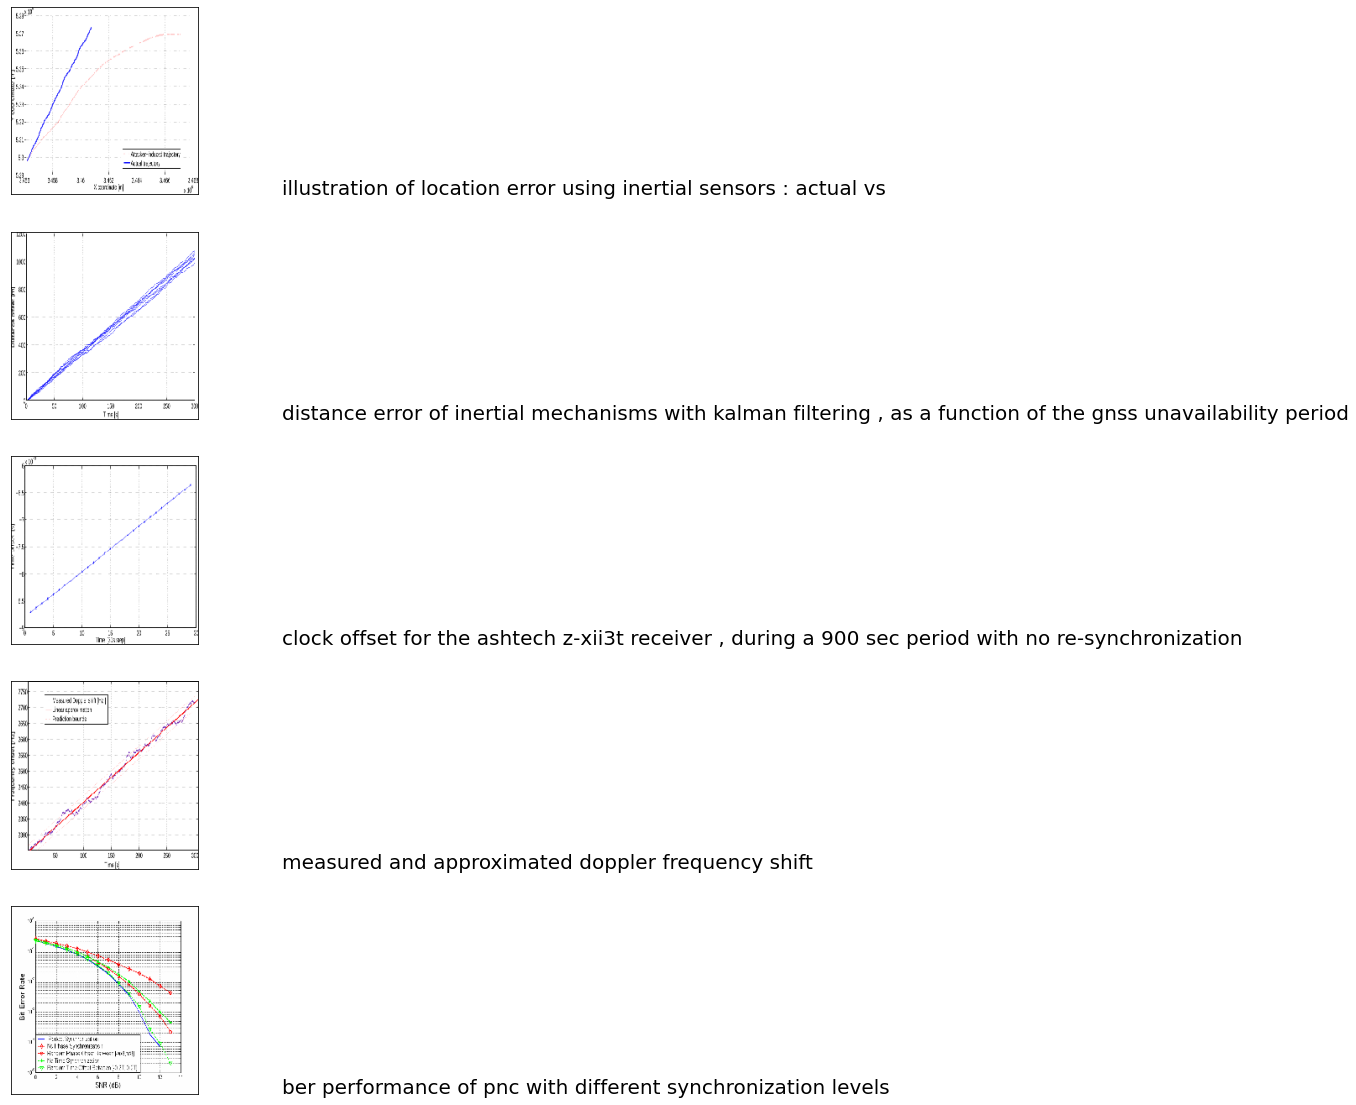

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image

dir_Flickr_jpg = r"scicap_data/SciCap-No-Subfig-Img/train"

if IN_COLAB:
      dir_Flickr_jpg = r"/content/" + dir_Flickr_jpg

npic = 5 # Displaying 5 images from the dataset
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

## Cleaning captions for further analysis

In [ ]:
# Defining a function to calculate the top 3 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 10102


,word,count
0,of,4621
1,the,4343
2,",",2836


## Cleaning the captions for further processing
The caption dataset contains punctuations, singular words and numerical values that need to be cleaned before it is fed to the model because uncleaned dataset will not create good captionsfor the images

In [ ]:
import string
text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove punctuations..
I ate 1000 apples and a banana I have python v27 Its 230 pm Could you buy me iphone7

Remove a single character word..
 ate 1000 apples and banana have python v27 Its 230 pm Could you buy me iphone7

Remove words with numeric values..
    ate        : True
    1000       : False
    apples     : True
    and        : True
    banana     : True
    have       : True
    python     : True
    v27        : False
    Its        : True
    230        : False
    pm         : True
    Could      : True
    you        : True
    buy        : True
    me         : True
    iphone7    : False
 ate apples and banana have python Its pm Could you buy me


In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

## Plotting the top 50 words that appear in the cleaned dataset

Vocabulary Size: 8221


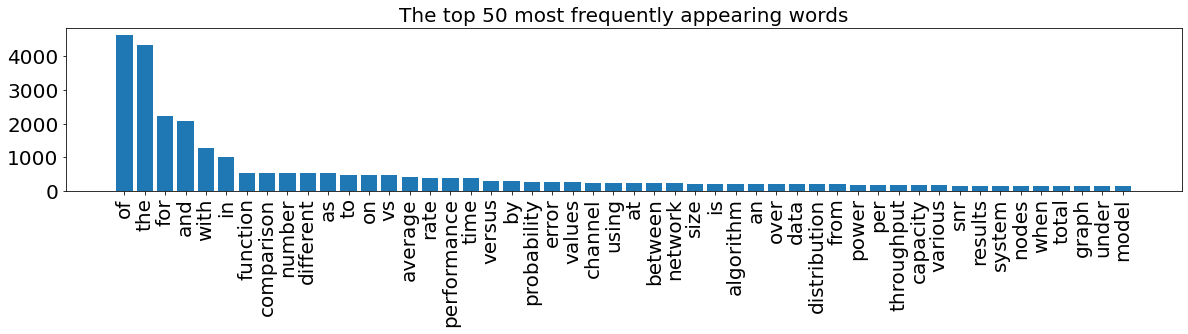

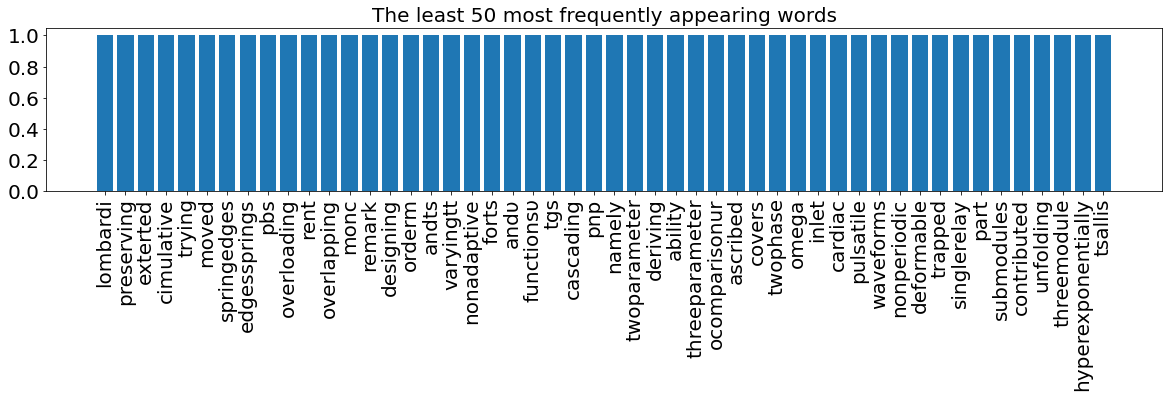

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

## Adding start and end sequence tokens for each captions 
Start and end sequence has to be added to the tokens so that it is easier to identify the captions for the images as each of them are of different length

In [ ]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [ ]:
df_txt0[:5]

,filename,caption
0,1001.0025v1-Figure4-1.png,startseq illustration of location error using...
1,1001.0025v1-Figure5-1.png,startseq distance error of inertial mechanism...
2,1001.0025v1-Figure6-1.png,startseq clock offset for the ashtech receive...
3,1001.0025v1-Figure7-1.png,startseq measured and approximated doppler fr...
4,1001.0069v1-Figure10-1.png,startseq ber performance of pnc with differen...


## Loading VGG16 model and weights to extract features from the images
The pre-trained weights for the VGG-16 model can be downloaded from [here](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5).

In [ ]:
#from keras.applications import VGG16

import keras
from keras.applications.vgg16 import VGG16 #vggmodel = VGG16(weights='imagenet', include_top=True)

modelvgg = VGG16(include_top=True,weights='imagenet')
## load the locally saved weights 
#modelvgg.load_weights("Data/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Deleting the last layer of the model 
The last layer of the VGG-16 is excluded here because we are are just using it for extracting the features rather than using for object classification.

In [ ]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Feature extraction
Here the features are extracted from all the images in the dataset. VGG-16 model gives out 4096 features from the input image of size 224 * 224

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

#image will hyave the feature vector from VGG16 last layer of flatten before classification layer.
images = OrderedDict()
npix = 224 #image size is fixed at 224 because VGG16 model has been pre-trained to take that size.
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    #store feature vector
    images[name] = y_pred.flatten()

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

dumped = json.dumps(images, cls=NumpyEncoder)
NUMBER_OF_IMAGES_USED = 10000

basename = "FeatureVector/ImageFeature"
logname = "%s %s %s.json" % (basename,NUMBER_OF_IMAGES_USED/1000 ,time.strftime("k %a %b %d %H %M %S %Y", time.localtime()))
print(logname)
with open(logname, 'w') as f:
    json.dump(dumped, f)

## Plotting similar images from the dataset
For this we have to first create a cluster and find which images belong together. Hence PCA is used to reduce the dimensions of the features which we got from VGG-16 festure extraction from **4096** to **2**

First the clusters are plotted and few examples are taken from the bunch for displaying

In [ ]:
from sklearn.decomposition import PCA

encoder = np.array(list(images.values()))
#print(encoder)
pca = PCA(n_components=2)
#print(pca)
y_pca = pca.fit_transform(encoder)

IndexError: ignored

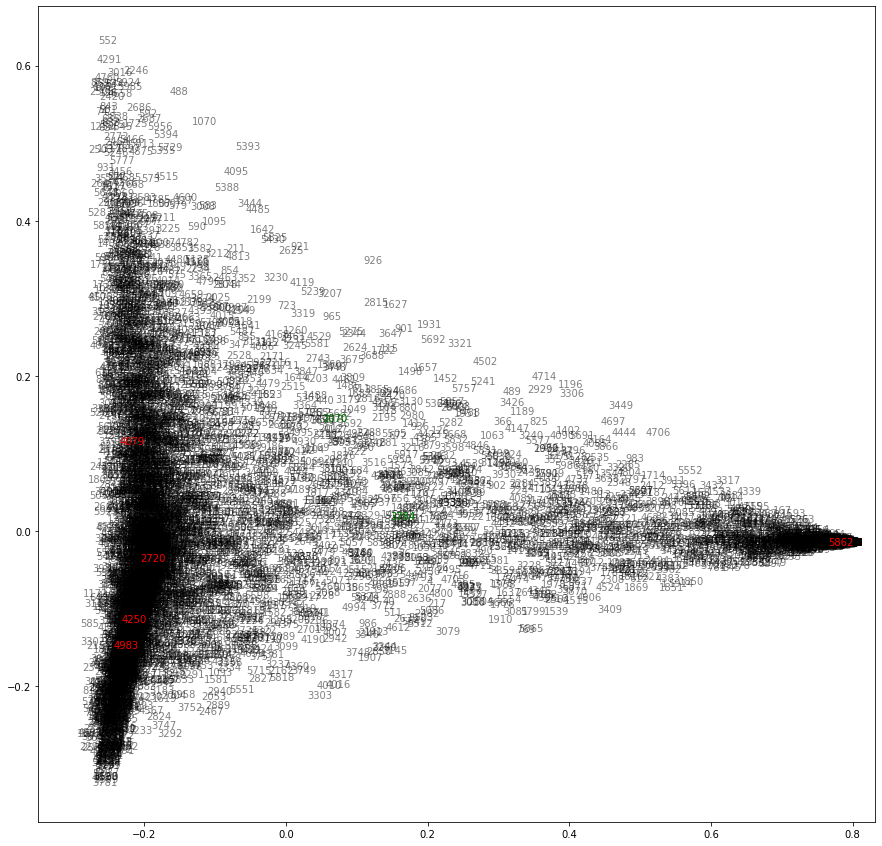

In [ ]:
## some selected pictures that are creating clusters
#these are just to display the related images from the dataset
picked_pic = OrderedDict()
picked_pic["red"]     = [2720,4250,4983,5862,4079]
picked_pic["green"]   = [2070,3784,7545,4644, 4997]
picked_pic["magenta"] = [6320,3432,1348,7472, 1518]
picked_pic["blue"]    = [3901,2168,3465,5285,5328]
picked_pic["yellow"]  = [144,1172,4423,4780,4448]
picked_pic["purple"]  = [5087]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0],y_pca[:,1],c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow,y_pca[irow,:],color="black",alpha=0.5) #annotate() is used to place text at the location of the point
for color, irows in picked_pic.items():
    for irow in irows:
        ax.annotate(irow,y_pca[irow,:],color=color)
ax.set_xlabel("pca embedding 1",fontsize=30)
ax.set_ylabel("pca embedding 2",fontsize=30)
plt.show()


## plot of images 
fig = plt.figure(figsize=(16,20))
count = 1
for color, irows in picked_pic.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
    
        ax = fig.add_subplot(len(picked_pic),5,count,
                         xticks=[],yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec,color))
plt.show()

## Merging the images and the captions for training

In [ ]:
dimages = []

for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])


#fnames are the names of the image files        
fnames = df_txt0["filename"]
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"]
#dimages are the actual features of the images
dimages = np.array(dimages)

In [ ]:
df_txt0

,filename,caption
0,1001.0025v1-Figure4-1.png,startseq illustration of location error using...
1,1001.0025v1-Figure5-1.png,startseq distance error of inertial mechanism...
2,1001.0025v1-Figure6-1.png,startseq clock offset for the ashtech receive...
3,1001.0025v1-Figure7-1.png,startseq measured and approximated doppler fr...
4,1001.0069v1-Figure10-1.png,startseq ber performance of pnc with differen...
...,...,...
5995,1112.6320v2-Figure3-1.png,startseq average complexity versus for the en...
5996,1112.6344v1-Figure2-1.png,startseq variation of characteristic distance...
5997,1112.6371v1-Figure4-1.png,startseq tsallis entropy versus for different...
5998,1112.6414v2-Figure3-1.png,startseq picture in parameter space for compl...


In [ ]:
fnames

0        1001.0025v1-Figure4-1.png
1        1001.0025v1-Figure5-1.png
2        1001.0025v1-Figure6-1.png
3        1001.0025v1-Figure7-1.png
4       1001.0069v1-Figure10-1.png
                   ...            
5995     1112.6320v2-Figure3-1.png
5996     1112.6344v1-Figure2-1.png
5997     1112.6371v1-Figure4-1.png
5998     1112.6414v2-Figure3-1.png
5999     1201.0070v1-Figure6-1.png
Name: filename, Length: 6000, dtype: object

In [ ]:
dcaptions

0       startseq  illustration of location error using...
1       startseq  distance error of inertial mechanism...
2       startseq  clock offset for the ashtech receive...
3       startseq  measured and approximated doppler fr...
4       startseq  ber performance of pnc with differen...
                              ...                        
5995    startseq  average complexity versus for the en...
5996    startseq  variation of characteristic distance...
5997    startseq  tsallis entropy versus for different...
5998    startseq  picture in parameter space for compl...
5999    startseq  increasing data points an example wi...
Name: caption, Length: 6000, dtype: object

In [ ]:
dimages

array([[5.2891141e-07, 2.0212339e-05, 2.0359398e-06, ..., 2.4810831e-06,
        6.6596833e-05, 9.6979918e-04],
       [4.2847546e-08, 5.9978461e-06, 2.6343740e-08, ..., 6.9390591e-09,
        1.6961482e-06, 1.4444059e-06],
       [8.0373148e-09, 1.2729365e-07, 1.3643616e-08, ..., 1.8097164e-09,
        1.3980807e-07, 3.3735348e-06],
       ...,
       [2.9297633e-08, 3.7680052e-06, 1.2408735e-08, ..., 8.2310887e-09,
        4.2335823e-06, 3.0136684e-06],
       [1.5940923e-05, 4.4486564e-04, 2.3321310e-05, ..., 4.5788524e-06,
        1.2768670e-04, 5.0653872e-04],
       [1.4597482e-05, 1.2685185e-04, 2.8865347e-06, ..., 1.4178777e-06,
        4.7713500e-05, 2.1070349e-05]], dtype=float32)

In [ ]:
df_txt0[:5]

,filename,caption
0,1001.0025v1-Figure4-1.png,startseq illustration of location error using...
1,1001.0025v1-Figure5-1.png,startseq distance error of inertial mechanism...
2,1001.0025v1-Figure6-1.png,startseq clock offset for the ashtech receive...
3,1001.0025v1-Figure7-1.png,startseq measured and approximated doppler fr...
4,1001.0069v1-Figure10-1.png,startseq ber performance of pnc with differen...


## Tokenizing the captions for further processing
As the model can't take texts as an input, they need to converted into vectors.

In [ ]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 8224
[[1, 215, 3, 460, 24, 27, 2604, 911, 461, 16, 2], [1, 59, 24, 3, 2604, 3917, 7, 1943, 1944, 13, 9, 3, 4, 3918, 3919, 432, 2], [1, 1541, 1945, 5, 4, 3920, 239, 186, 912, 432, 7, 130, 3921, 2], [1, 312, 6, 1129, 913, 157, 1542, 2], [1, 54, 19, 3, 1543, 7, 12, 1130, 204, 2]]


## Splitting the training and test data

In [ ]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [ ]:
#print(dt_test)
#print(dt_val)
print(dt_train)

[[1, 10, 3, 2042, 3261, 15, 192, 1384, 14, 71, 1220, 197, 3, 319, 122, 2], [1, 2042, 3261, 6, 192, 1384, 14, 197, 3, 5413, 122, 27, 5414, 5415, 15, 5416, 81, 2347, 2], [1, 4, 712, 8, 13, 4, 156, 32, 1409, 2], [1, 4, 37, 3, 4, 5417, 669, 93, 2], [1, 250, 389, 3, 722, 2348, 2], [1, 250, 389, 3, 722, 3262, 2], [1, 59, 29, 250, 6, 252, 303, 2], [1, 3263, 230, 6, 62, 45, 5, 4, 67, 79, 782, 24, 8, 1081, 1661, 3264, 5418, 7, 85, 306, 59, 67, 15, 4, 102, 1831, 2], [1, 62, 45, 5, 4, 67, 79, 24, 8, 34, 1444, 1661, 622, 5419, 60, 7, 85, 5420, 5421, 2], [1, 99, 3, 85, 4, 11, 3, 5422, 46, 15, 3263, 273, 7, 12, 306, 914, 5423, 2], [1, 11, 3, 564, 5424, 5, 5425, 6, 5426, 5, 12, 380, 122, 2], [1, 4, 5427, 242, 91, 905, 425, 16, 1281, 231, 3265, 2], [1, 34, 82, 118, 3, 1281, 231, 3265, 5, 5428, 3, 105, 46, 221, 5429, 4, 905, 3266, 242, 91, 169, 32, 86, 66, 14, 4, 1281, 231, 2], [1, 195, 7, 4, 5430, 3, 4, 1197, 188, 2], [1, 216, 348, 3, 3267, 6, 3268, 38, 4, 550, 217, 13, 9, 3, 2], [1, 216, 348, 3, 3267

In [ ]:
print(len(di_test),  len(di_val), len(di_train))

1200 1200 3600


## Finding the max length of the caption

In [ ]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

60


## Processing the captions and images as per the required shape by the model

In [ ]:
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    #assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 3600
 (40299, 60) (40299, 1000) (40299, 8224)
# captions/images = 1200
 (13835, 60) (13835, 1000) (13835, 8224)
# captions/images = 1200
 (13224, 60) (13224, 1000) (13224, 8224)


## Building the LSTM model

In [ ]:
Ximage_train.shape

(40299, 1000)

In [ ]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)
#,return_sequences=True
#,activation='relu'
se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256,name="CaptionFeature2")(se2)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

8224
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 64)       526336      ['input_3[0][0]']                
                                                                                                  
 CaptionFeature (LSTM)          (None, 60, 256)      328704      ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 60, 256)      0           ['CaptionFeature[0][0]']         
                                                                                       

## Training the LSTM model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# fit model
import time
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()))
start = time.time()

# define the checkpoint
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# fit model using our gpu
with tf.device('/gpu:0'):
    hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                      epochs=6, verbose=1, 
                      batch_size=128,
                      validation_data=([Ximage_val, Xtext_val], ytext_val),callbacks=[tensorboard])
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/6
315/315 [==============================] - 537s 2s/step - loss: 5.5305 - val_loss: 6.3304
Epoch 2/6
315/315 [==============================] - 525s 2s/step - loss: 5.4203 - val_loss: 6.3243
Epoch 3/6
315/315 [==============================] - 520s 2s/step - loss: 5.3062 - val_loss: 6.3774
Epoch 4/6
315/315 [==============================] - 526s 2s/step - loss: 5.1912 - val_loss: 6.4158
Epoch 5/6
315/315 [==============================] - 512s 2s/step - loss: 5.0808 - val_loss: 6.5269
Epoch 6/6
315/315 [==============================] - 518s 2s/step - loss: 4.9756 - val_loss: 6.5684
TIME TOOK 52.37MIN


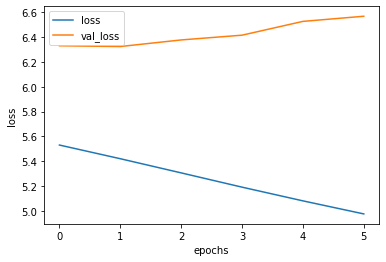

In [ ]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Generating captions on a small set of images
After the model finishes training we can test out its performance on the some of the test images to figure out if the generated captions are good enough. If the generated captions are good enough we can generate the captions for the whole test dataset.

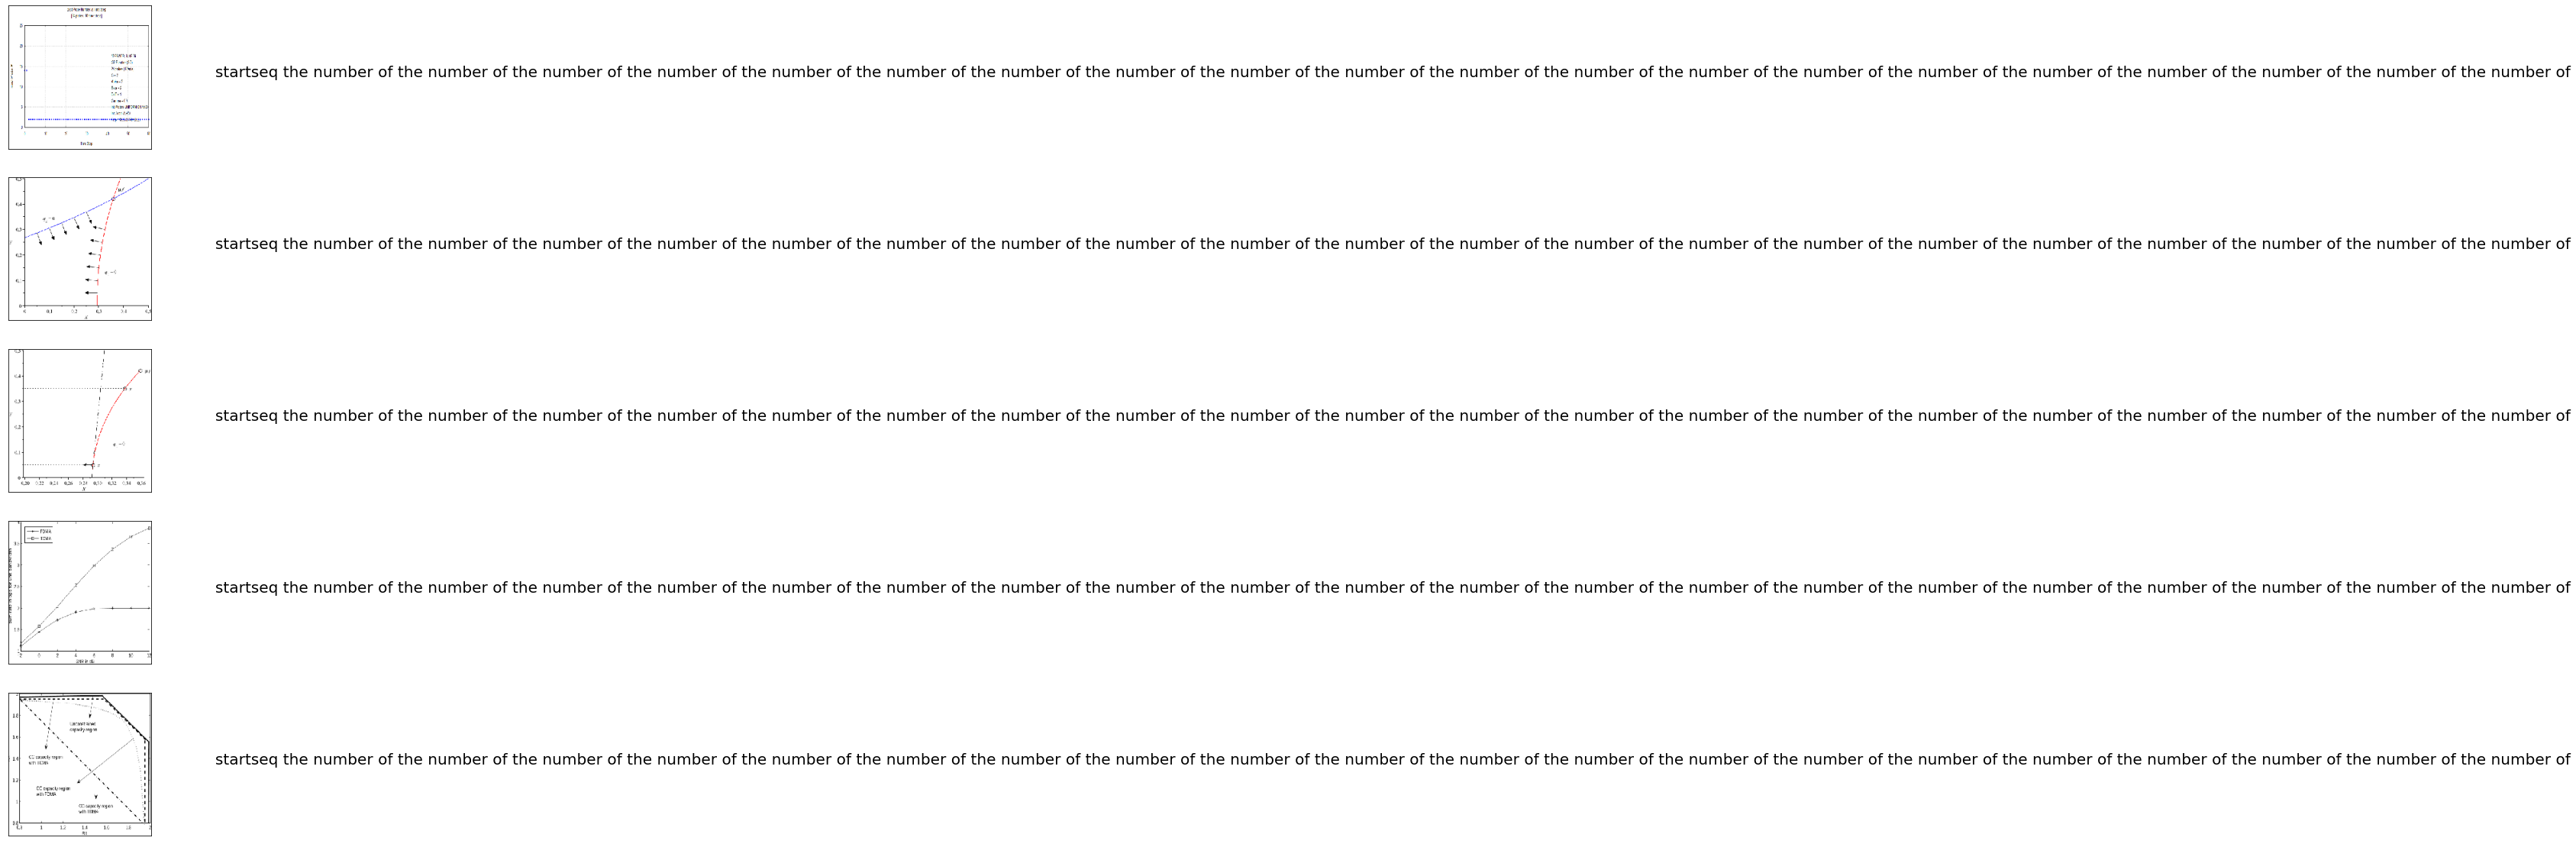

In [ ]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[8:13],di_test[8:13]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

## Evaluating the model performance
After the model is trained we have to test the models prediction capabilities on test dataset. Traditional accuracy metric can't be used on predictions. For text evaluations we have a metric called as [BLEU Score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/). BLEU stands for Bilingual Evaluation Understudy, it is a score for comparing a candidate text to one or more reference text.

Example:

In [ ]:
hypothesis = "I like dog"
hypothesis = hypothesis.split()
reference  = "I like dog"
references = [reference.split()] ## references must be a list containing list. 

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
print("BLEU={:4.3f}".format(sentence_bleu(references,hypothesis)))

BLEU=1.000


In [ ]:
hypothesis2 = "I love dog!".split()
print("BLEU={:4.3f}".format(sentence_bleu(references,  hypothesis2))) 

BLEU=0.760


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


In [ ]:
hypothesis = "I like a dog named harsit"
hypothesis = hypothesis.split()
reference  = "I like a dog named harsit"
references = [reference.split()] ## references must be a list containing list.
from nltk.translate.bleu_score import sentence_bleu
print("BLEU={:4.3f}".format(sentence_bleu([reference],hypothesis)))

BLEU=0.032


## Generating captions for the whole test data and finding BLEU score

In [ ]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    print(bleu)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

0.360817004838774
0.17207204192741243
0.360817004838774
0
0.360817004838774
0.360817004838774
0.360817004838774
0.17207204192741243
0.360817004838774
0.17207204192741243
0.4748618834996642
0
0
0
0
0.360817004838774
0.360817004838774
0.360817004838774
0.360817004838774
0
0.26930729948231735
0.42908614936824124
0.42908614936824124
0.42908614936824124
0
0
0.42908614936824124
0.360817004838774
0.23250376969028214
0.23250376969028214
0
0
0.1554846418508471
0.360817004838774
0.1554846418508471
0
0.19551158646553354
0
0.42908614936824124
0.1554846418508471
0.17207204192741243
0.17207204192741243
0.360817004838774
0.360817004838774
0.27988835032260767
0.18490344236267722
0.18490344236267722
0.360817004838774
0.42908614936824124
0.4748618834996642
0.42908614936824124
0.1554846418508471
0.21988848924619128
0.23250376969028214
0
0.08002649231807342
0.360817004838774
0.4748618834996642
0.1554846418508471
0.1554846418508471
0.1554846418508471
0
0
0
0.360817004838774
0
0
0
0
0
0
0.42908614936824124


In [ ]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.199


## Good and bad captions examples from the model
We can check out some of the generated caption's quality. Some times due to the complex nature of the images the generated captions are not acceptable. Below you would find some examples

Bad Caption
/content/scicap_data/SciCap-No-Subfig-Img/train/1001.0025v1-Figure5-1.png
/content/scicap_data/SciCap-No-Subfig-Img/train/1001.0025v1-Figure7-1.png
/content/scicap_data/SciCap-No-Subfig-Img/train/1001.0080v1-Figure4-1.png
/content/scicap_data/SciCap-No-Subfig-Img/train/1001.0340v3-Figure6-1.png
/content/scicap_data/SciCap-No-Subfig-Img/train/1001.0357v1-Figure10-1.png


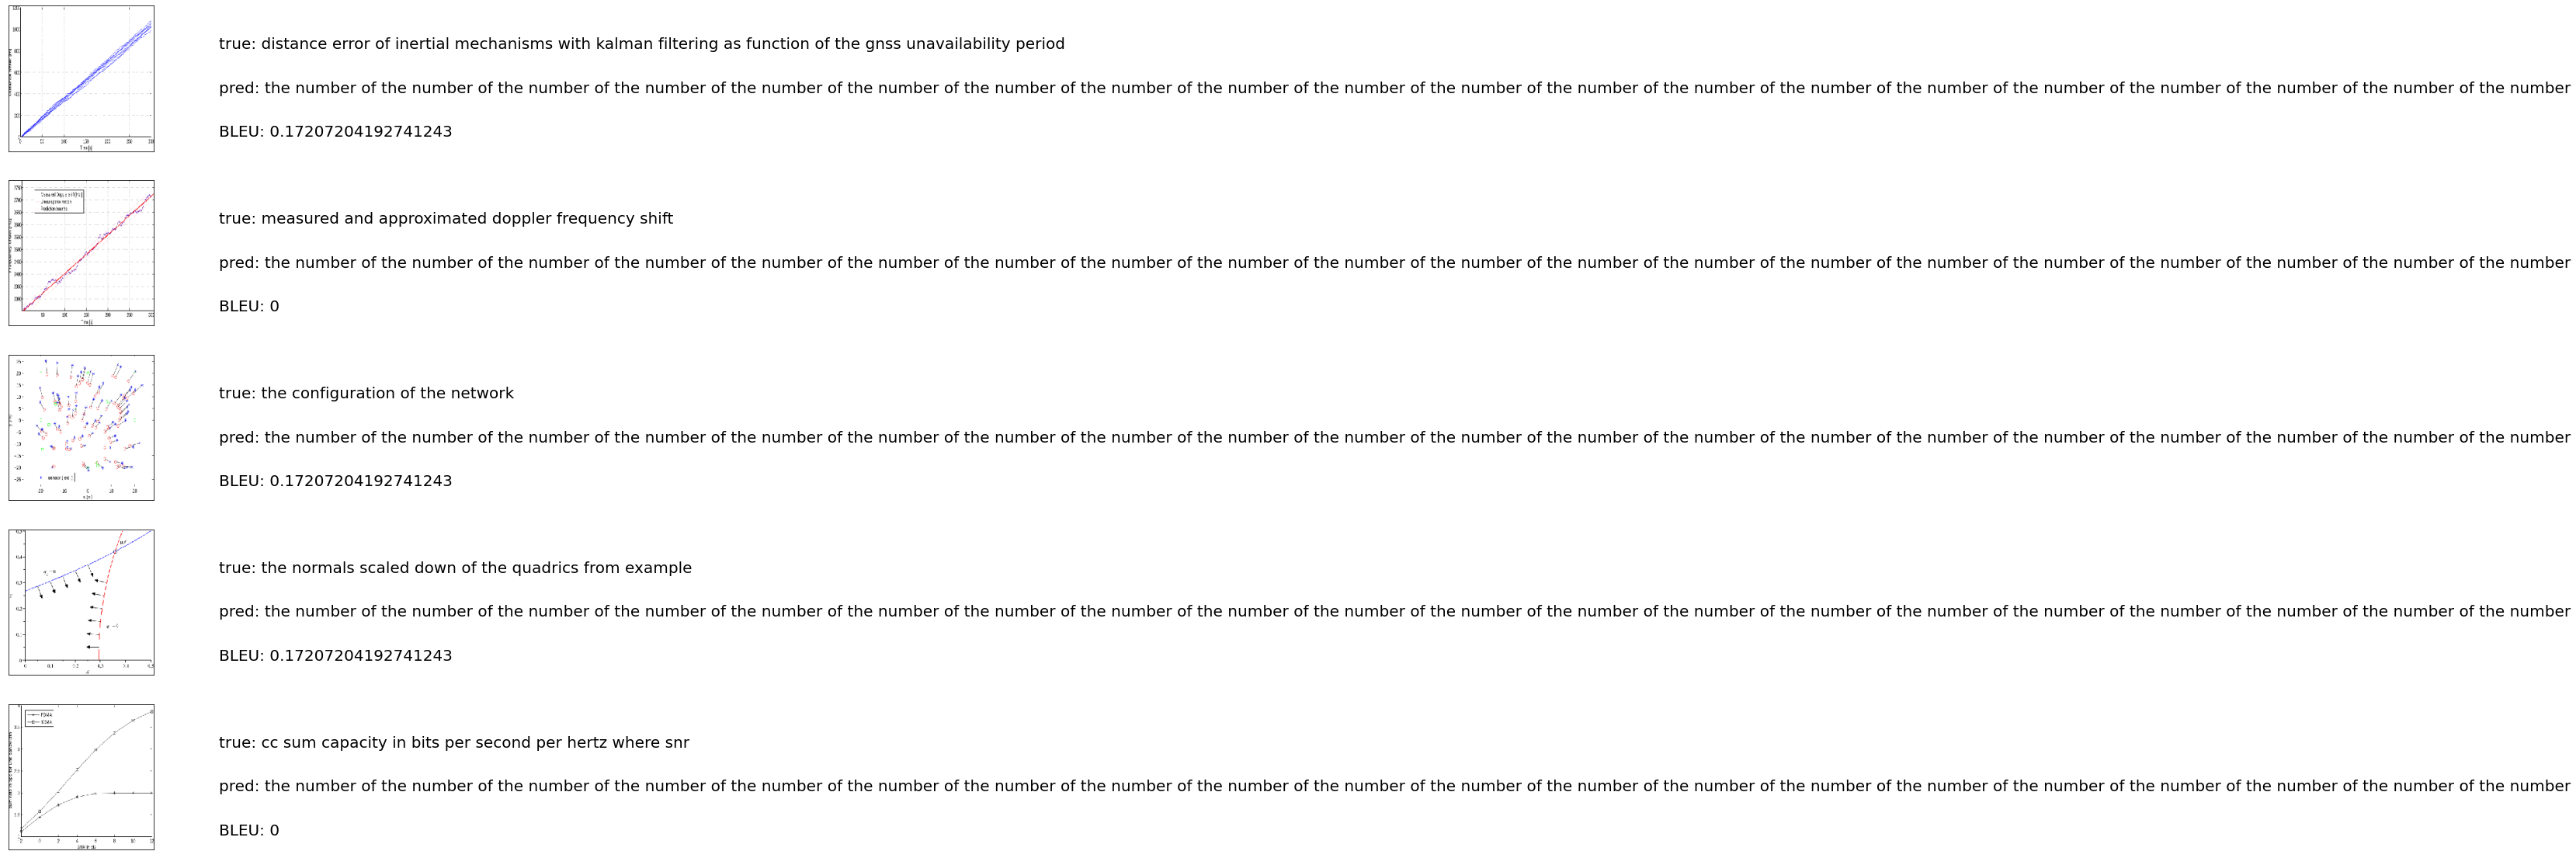

Good Caption


<Figure size 720x1440 with 0 Axes>

In [ ]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        #ax.text(0,0.1,"filename: {}".format(filename),fontsize=20)
        print(filename)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)

## Conclusion
The model has been successfully trained to generate the captions as expected for the images. The caption generation has constantly been improved by fine tuning the model with different hyper parameter. Higher BLEU score indicates that the generated captions are very similar to those of the actual caption present on the images. Below you will find a table displaying different BLEU scores obtained by tuning the parameters:

![](images/table.png?raw=true)

With the help of Tensorboard, we were able to see how different training process had an impact on the model. 

![](images/tensorboard.PNG?raw=true)

The validation loss falls upto 5th epoch and then increases afterwards, while the training loss still continues falling

The following were the major outcomes and aboservations of the training process and testing the model on the test data:
* The validation loss increases after 5th epoch in most cases even though the training loss decreases over time. This indicates that the model is over fitting and the training needs to stop.
* Higher BLEU score doesn't aways translate to better generated captions. If the model overfits on your training data, it will lead the model to go through details in the image and generate out captions which don't make sense. It can be seen in the good and the bad captions generated above.

In [ ]:
basename = "model/model_weights "
logname = "%s %s.h5" % (basename, time.strftime("%a %b %d %H %M %S %Y", time.localtime()))

#saving weights
model.save_weights(logname)

In [ ]:
#with open('/content/model/model_weights.h5', 'w') as f:
#  f.write('content')



In [ ]:
from google.colab import files
files.download( "/content/model/model_weights.h5" ) 